In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
#-- 아래 코드는 옵션
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

sns.set()

## Matplotlib에 한글 표시

방법1) 비추 -- 복잡하다, 사용자마다 폰트 위치가 다르다

In [2]:
# import matplotlib.font_manager as fm
# import matplotlib as mpl
# mpl.rcParams['axes.unicode_minus'] = False

# path = 'C:\\\\Windows\\\\Fonts\\\\\\x7f\\x7f\\x7f\\x7fBOLD.TTF'
# font_name = fm.FontProperties(fname=path, size=10).get_name()
# print(font_name)
# plt.rc('font', family=font_name)
# plt.title('한글제목')
# plt.show()

방법2) 추천 -- 간단하다, 다양한 폰트체가 없다

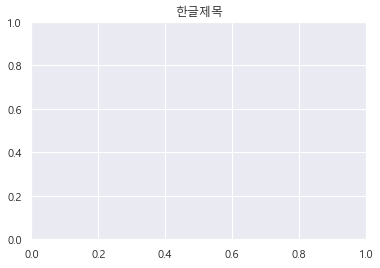

In [3]:
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False   # 차트에 +,- 기호 표시 

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.title('한글제목')
plt.show()

<pre>
3500rows       2,482rows
X_train.csv,   X_test.csv
y_train.csv    ___________ -->제출답안(submission.csv) 
</pre>
* submisstion.csv  X_test.cust_id  gender(proba[:, 1])
* target : gender(0: 여자, 1: 남자)
* X_train, y_train : cust_id

In [4]:
# y = df['target']
# X = df.drop(['target'], axis=1)

In [5]:
y = pd.read_csv("./Quiz2/y_train.csv")
X = pd.read_csv("./Quiz2/X_train.csv")
test문제 = pd.read_csv("./Quiz2/X_test.csv")

In [6]:
test답안= pd.DataFrame({"cust_id":test문제['cust_id'].values})
test답안["gender"] = 0.0
test답안.head()
# test답안.to_csv("submitsion.csv", index=False)

,cust_id,gender
0,3500,0.0
1,3501,0.0
2,3502,0.0
3,3503,0.0
4,3504,0.0


In [7]:
X.shape, y.shape, test문제.shape, test답안.shape

((3500, 10), (3500, 2), (2482, 10), (2482, 2))

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  3500 non-null   int64  
 1   총구매액     3500 non-null   int64  
 2   최대구매액    3500 non-null   int64  
 3   환불금액     1205 non-null   float64
 4   주구매상품    3500 non-null   object 
 5   주구매지점    3500 non-null   object 
 6   내점일수     3500 non-null   int64  
 7   내점당구매건수  3500 non-null   float64
 8   주말방문비율   3500 non-null   float64
 9   구매주기     3500 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 273.6+ KB


In [9]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   cust_id  3500 non-null   int64
 1   gender   3500 non-null   int64
dtypes: int64(2)
memory usage: 54.8 KB


In [10]:
test문제.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2482 entries, 0 to 2481
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  2482 non-null   int64  
 1   총구매액     2482 non-null   int64  
 2   최대구매액    2482 non-null   int64  
 3   환불금액     871 non-null    float64
 4   주구매상품    2482 non-null   object 
 5   주구매지점    2482 non-null   object 
 6   내점일수     2482 non-null   int64  
 7   내점당구매건수  2482 non-null   float64
 8   주말방문비율   2482 non-null   float64
 9   구매주기     2482 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 194.0+ KB


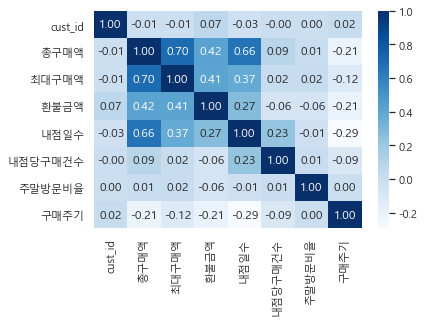

In [11]:
sns.heatmap(X.corr(), fmt='.2f', annot=True, cmap='Blues')
plt.show()

## 분석전략
* 글자처리 - 2
* 결측처리(숫자) - 1 
* 삭제처리 - cust_id
* 수치 정규화/표준화 - 스케일러
* 분류알로리즘(앙상블) : XGBoostClassifier, LightGBMClassifier, RandomForestClassifier
* 점수 : roc_auc_score(정답, proba[:, 1]) 
* 초매개변수 최적화 : GridSearchCV()  {'n_estimater':[100], 'max_depth':[1,2]}

### 전처리

#### 결측처리(숫자) -  환불금액


In [12]:
# X.isna().sum()           #2295
# test문제.isna().sum()    #1611

In [13]:
X.columns

Index(['cust_id', '총구매액', '최대구매액', '환불금액', '주구매상품', '주구매지점', '내점일수', '내점당구매건수',
       '주말방문비율', '구매주기'],
      dtype='object')

In [14]:
X['환불금액'] = X['환불금액'].fillna(0)
test문제['환불금액'] = test문제['환불금액'].fillna(0)

#### 삭제처리 - cust_id
* X, y 합쳐서(조인) df를 만들필요는 없다
* test문제 - submission.csv

In [15]:
test문제['cust_id'].values

array([3500, 3501, 3502, ..., 5979, 5980, 5981], dtype=int64)

In [16]:
X = X.drop('cust_id', axis=1)
y = y.drop('cust_id', axis=1)
test문제 = test문제.drop('cust_id', axis=1)

### 글자처리

In [17]:
#--- by 오선호
# dict = {'기타':0,
#         '농산물':1, '수산품':1, '건강식품':1, '차/커피':1, '젓갈/반찬':1, 
#         '가공식품':2,'주류':2,'육류':2,'축산가공':2,
#        '화장품':3,'액세서리':3,'보석':3,
#         '디자이너':4,'명품':4,'섬유잡화':4,'모피/피혁':4,'피혁잡화':4,'아동':4,'셔츠':4,'란제리/내의':4,
#         '시티웨어':5,'캐주얼':5,'골프':5,'스포츠':5,'일용잡화':5,'남성 캐주얼':5,'구두':5,'트래디셔널':5,'남성정장':5,'남성 트랜디':5,
#        '주방용품':6,'주방가전':6,'생활잡화':6,'가구':6,'커리어':6,'식기':6,'침구/수예':6,'악기':6,'소형가전':6,
#         '통신/컴퓨터':7,'대형가전':7}
# train_test['주구매상품_'] = train_test['주구매상품'].map(dict)
# train_test[['주구매상품','주구매상품_']].head()


선택1)

In [18]:
# temp = pd.concat( [X['주구매상품'], test문제['주구매상품']], axis=0)
# arr = temp.unique()
# dict1 = {}
# for i, v in enumerate(arr):
#     dict1[v] = i
    

# X['주구매상품'] = X['주구매상품'].map(dict1)
# test문제['주구매상품'] = test문제['주구매상품'].map(dict1)

# # #------------------    
# temp = pd.concat( [X['주구매지점'], test문제['주구매지점']], axis=0)
# arr = temp.unique()
# dict2 = {}
# for i, v in enumerate(arr):
#     dict2[v] = i
# X['주구매지점'] = X['주구매지점'].map(dict2)
# test문제['주구매지점'] = test문제['주구매지점'].map(dict2)

# # print(dict1, dict2)

선택2) get_dummies()
* 결측  . 글자->숫자(인코딩) . 원핫인코딩 

In [19]:
tot_df = pd.concat( [X, test문제], axis=0)
print(tot_df.shape)
tot_df = pd.get_dummies(tot_df)
print(tot_df.shape)

(5982, 9)
(5982, 73)


In [20]:
# len(X.index) #3500
# X.shape[0]   #3500
X = tot_df.iloc[:3500 , :]
test문제 = tot_df.iloc[3500: , :]
print(X.shape, test문제.shape, X.shape[0]+test문제.shape[0])

(3500, 73) (2482, 73) 5982


### 수치 정규화/표준화 - 스케일러

In [21]:
sc = StandardScaler()
sc.fit(X)                #데이터프레임통째로
X_sc = sc.transform(X)   #행렬 [[],[],[]]
test_sc = sc.transform(test문제)

### 분류 알고리즘(앙상블) 
* XGBoostClassifier, LightGBMClassifier, RandomForestClassifier


#### 선택1) 여기서 끝낼거면 -- GridSearchCV()잘 못하겠다

In [22]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1212)
# model = RandomForestClassifier()
# model.fit(X_train, y_train)
# proba = model.predict_proba(X_val)
# # print(proba)
# roc_auc_score(y_val, proba[ : , 1])  #0.654358103249928

#### 선택2) GridSearchCV()

* 초매개변수 최적화 
* GridSearchCV() {'n_estimater':[100], 'max_depth':[1,2]}

In [23]:
model = RandomForestClassifier()
model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [24]:
myparm = {'n_estimators':[300]}  #, 'max_depth':[1,2]}
gcv_model = GridSearchCV(model, param_grid=myparm, cv=5, refit=True, scoring='roc_auc')
gcv_model.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [300]}, scoring='roc_auc')

In [25]:
gcv_model.best_score_   #0.6532

0.6525944229463304

In [26]:
gcv_model.best_params_

{'n_estimators': 300}

### submission.csv 답안지 제출

In [27]:
proba = gcv_model.predict_proba(test문제)  #-------------완전주의!!!!!!
print(proba[:5])
print(proba[:, 1])
제출답안_arr = proba[:, 1]
print(len(제출답안_arr))
# -----------------------------------------------------------------
# 완전주의!!!!!! 'test문제' 답안은 주최자만 가지고 있다...... 점수못찍는다
# -----------------------------------------------------------------
# roc_auc_score( __??__, proba[ : , 1])  #--- error

[[0.43       0.57      ]
 [0.85666667 0.14333333]
 [0.81333333 0.18666667]
 [0.64666667 0.35333333]
 [0.58333333 0.41666667]]
[0.57       0.14333333 0.18666667 ... 0.52333333 0.43       0.51333333]
2482


In [28]:
len(test답안['gender'].values)

2482

* DataFrame에 array데이터를 붙이는 방법

In [29]:
# test답안['gender'] = proba[:, 1].reshape(-1,1)
test답안['gender'] = 제출답안_arr.reshape(-1,1)

In [30]:
test답안.head()

,cust_id,gender
0,3500,0.570000
1,3501,0.143333
2,3502,0.186667
3,3503,0.353333
4,3504,0.416667


In [31]:
test답안.to_csv("lkh.csv", index=False)

* lkh.csv  재확인

In [32]:
# dd = pd.read_csv("lkh.csv")
# dd.head()
# dd.shape